In [1]:
from pathlib import Path
import sys

proj_path = Path().resolve()

    
from aib9_lib import aib9_tools as aib9
import numpy as np
import torch
import os
seed = 42
np.random.seed(seed)
torch.manual_seed(seed)

if torch.backends.mps.is_available():
    device = torch.device('mps')
elif torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('cpu')
print(f'Using device: {device}')

Using device: mps


重要的函数是这几个：
1. xyz = np.load(aib9.FULL_DATA)  shape (ntrajs, nframes, 58, 3), 忽略前两维就行，我们不需要考虑时间维度。
2. kai_calculator, 化学里叫collective variable, 是两个重要的变量，相当于降维度，可以用于可视化。这个cv是旋转平移不变，但是镜面对称会使cv中心对称
3. py3dplot，3d可视化，用于查看分子结构，大概肉眼判断生成模型的效果。

现在数据集应该是比较对称的。实验步骤如下：
1. 取cv[0]>0部分的数据。即分布图的右半部分
2. 用普通vae训练一下，并用新vae训练一下
3. 比较两者的效果，预计普通vae生成的分子的cv分布是中心对称的，但是新方法生成的分布只有右半部分



In [ ]:
xyz = np.load(aib9.FULL_DATA)  # (ntrajs, nframes, 58, 3)
print(xyz.shape)
dihedrals = aib9.dihedrals_calculator(xyz) # (ntrajs, nframes, 9, 2), 9 residues, 2 dihedrals per residue
kai = aib9.kai_calculator(xyz) #(ntrajs, nframes, 2) two CVs, kai is the linear combination of dihedrals
print(f'kai shape: {kai.shape}, dihedrals shape: {dihedrals.shape}')

(20, 50000, 58, 3)
kai shape: (20, 50000, 2), dihedrals shape: (20, 50000, 9, 2)


In [3]:

data=np.load(aib9.FULL_DATA).reshape(-1,58,3)
# shape (20, 50000, 58, 3)
data=data[:3,:,:]
cv=aib9.kai_calculator(data)
print("original cv:\n", cv)

# 镜面对称使cv中心对称
L=np.array([
    [-1,0,0],
    [0,1,0],
    [0,0,1]
])
sym_data=data@L
print("mirror sym cv:\n", aib9.kai_calculator(sym_data))

# 旋转不改变cv
random_matrix = np.random.randn(3, 3)
Q, R = np.linalg.qr(random_matrix)
orthogonal_matrix = Q
rot_data=data@orthogonal_matrix
print("rot cv:\n", aib9.kai_calculator(rot_data))

#平移也不改变
trans_data = data + np.array([1, 0, 0])
print("trans cv:\n", aib9.kai_calculator(trans_data))


original cv:
 [[-4.85281389 -0.0809402 ]
 [-4.63290246 -0.22834222]
 [-4.76778253 -0.05316738]]
mirror sym cv:
 [[4.85281389 0.0809402 ]
 [4.63290246 0.22834222]
 [4.76778253 0.05316738]]
rot cv:
 [[-4.85281389 -0.0809402 ]
 [-4.63290246 -0.22834222]
 [-4.76778253 -0.05316738]]
trans cv:
 [[-4.85281389 -0.0809402 ]
 [-4.63290246 -0.22834222]
 [-4.76778253 -0.05316738]]


Text(0, 0.5, 'kai2')

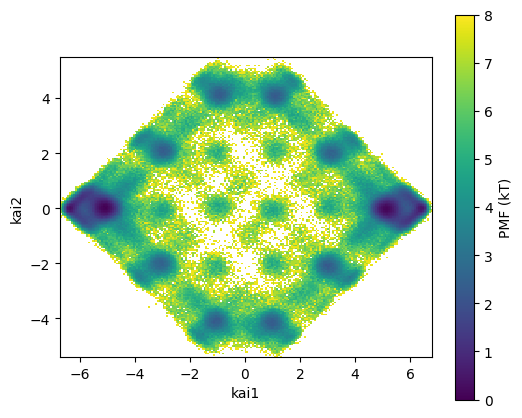

In [4]:
# plot the PMF
from scipy.stats import binned_statistic_2d
import matplotlib.pyplot as plt
nbins = 200
kai_flat = kai.reshape(-1, 2)
H, xedges, yedges, binnumber = binned_statistic_2d(kai_flat[:,0], kai_flat[:,1], None, statistic='count', bins=nbins)
H = H.T  # Transpose so that the orientation is correct
H = H / np.sum(H)  # Normalize to get a probability distribution
pmf = np.full_like(H, np.nan)
mask = H > 0
pmf[mask] = -np.log(H[mask])
pmf_min = np.nanmin(pmf)
pmf = pmf - pmf_min  
plt.figure(figsize=(6,5))
plt.imshow(pmf, origin='lower', extent=[xedges[0], xedges[-1], yedges[0], yedges[-1]], cmap='viridis', interpolation='nearest', vmin=0, vmax=8)
plt.colorbar(label='PMF (kT)')
plt.xlabel('kai1')
plt.ylabel('kai2')

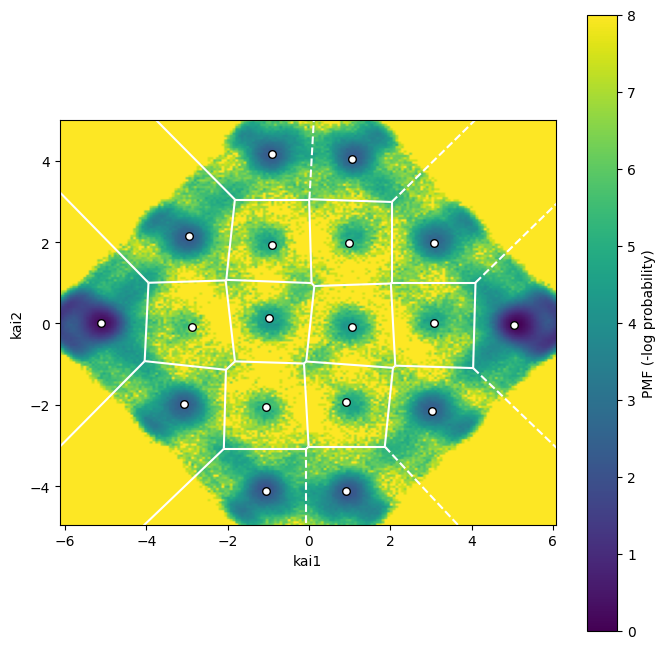

In [5]:
# or directly use the existing PMF function
fig, ax, im, mini = aib9.plot_pmf_base()#plot_pmf_base(pmf, xedges, yedges)
aib9.add_colorbar(fig, im)

In [7]:
data=np.load(aib9.FULL_DATA).reshape(-1,58,3)
coords=data[0]
view=aib9.py3dplot(coords)

3Dmol.js failed to load for some reason. Please check your browser console for error messages.